In [1]:
MODELO = "Propio-500Steps"

In [2]:
import os
import keras
keras.__version__
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [4]:
def get_session():
    """ Construct a modified tf session.
    """
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [5]:
keras.backend.tensorflow_backend.set_session(get_session())

# Modelo Propio CNN (conv2d)

In [6]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


# Modelo

In [8]:
from keras import layers
from keras import models

if multi_gpu > 1:
  
    with tf.device('/cpu:0'):
        model = models.Sequential()
        model.add(layers.Conv2D(512, (5, 5), activation='relu',input_shape=(300, 300, 3)))
        model.add(layers.Conv2D(512, (3, 3), activation='relu'))
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dropout(0.1))
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(120, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
if multi_gpu > 1:
    parallel_model = multi_gpu_model(model, gpus=multi_gpu)   

# Optimizador

In [10]:
from keras_radam import RAdam

parallel_model.compile(loss='categorical_crossentropy',
                       optimizer=RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-7),
                       metrics=['categorical_accuracy'])

# Callbacks

In [11]:
from keras import callbacks

callbacks = [callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20, restore_best_weights=True, mode='max')]

# Entrenamiento

In [12]:
history = parallel_model.fit_generator(train_generator,
                                       steps_per_epoch=500,
                                       epochs=2000,
                                       validation_data=valid_generator,
                                       validation_steps=200,
                                       callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
500/500 [==============================] - 626s 1s/step - loss: 4.7878 - categorical_accuracy: 0.0106 - val_loss: 4.7858 - val_categorical_accuracy: 0.0126
Epoch 2/2000
500/500 [==============================] - 590s 1s/step - loss: 4.7843 - categorical_accuracy: 0.0124 - val_loss: 4.7806 - val_categorical_accuracy: 0.0119
Epoch 3/2000
500/500 [==============================] - 592s 1s/step - loss: 4.7829 - categorical_accuracy: 0.0109 - val_loss: 4.7790 - val_categorical_accuracy: 0.0122
Epoch 4/2000
500/500 [==============================] - 594s 1s/step - loss: 4.7805 - categorical_accuracy: 0.0129 - val_loss: 4.7781 - val_categorical_accuracy: 0.0126
Epoch 5/2000
500/500 [==============================] - 593s 1s/step - loss: 4.7818 - categorical_accuracy: 0.0114 - val_loss: 4.7803 - val_categorical_accuracy: 0.0110
Epoch 6/2000
500/500 [==============================] - 592s 1s/step - loss: 4.7808 - categorical_accuracy:

In [13]:
import pickle

# open a file, where you ant to store the data
file = open('./models/history_{}.pkl'.format(MODELO), 'wb')

# dump information to that file
pickle.dump(history.history, file)

# close the file
file.close()

# Graficos

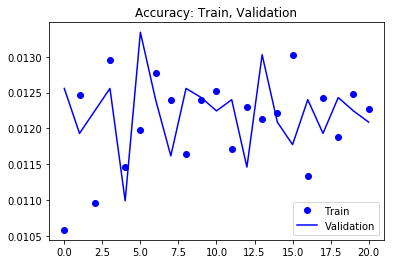

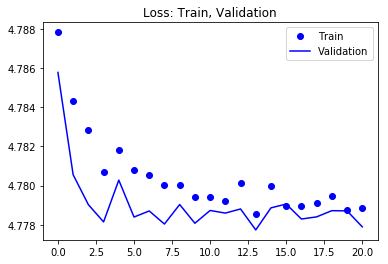

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline  

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [15]:
parallel_model.save('./models/model_{}_RAdam.h5'.format(MODELO))

# Predict

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 3025 images belonging to 120 classes.


In [17]:
probabilities = parallel_model.predict_generator(test_generator)

In [18]:
# Get Max Index
predicted_class_index=np.argmax(probabilities,axis=1)

# Dictionary: Index to Class
class_labels = list(test_generator.class_indices.keys())
index_to_labels = dict((v,k) for k,v in test_generator.class_indices.items())

# Get List of Predictions
predictions = [index_to_labels[ix] for ix in predicted_class_index]

# Get Dictionary of Predictions
results=pd.DataFrame({"Filename":test_generator.filenames,
                      "Predictions":predictions})

In [19]:
results.head()

,Filename,Predictions
0,n02085620-Chihuahua\n02085620_10074.jpg,n02085936-Maltese_dog
1,n02085620-Chihuahua\n02085620_10131.jpg,n02085936-Maltese_dog
2,n02085620-Chihuahua\n02085620_10621.jpg,n02085936-Maltese_dog
3,n02085620-Chihuahua\n02085620_1073.jpg,n02085936-Maltese_dog
4,n02085620-Chihuahua\n02085620_10976.jpg,n02085936-Maltese_dog


In [20]:
results.to_csv("./models/results_details_{}.csv".format(MODELO), sep="|", index=False)

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels, predicted_class_index)

In [22]:
def plot_confusion_matrix(cm, classes,
                          title=None,
                          cmap=plt.cm.Blues):

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

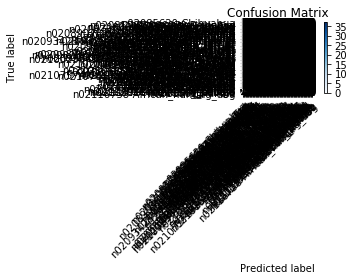

In [23]:
plot_confusion_matrix(cm, class_labels, 'Confusion Matrix')

In [24]:
results_dict = {}
tp_sum, fp_sum = 0, 0

for ix, row in enumerate(cm):
    
    tp = row[ix]
    fp = np.sum(row) - tp   
    results_dict[ix] = [class_labels[ix],tp,fp,(tp/(tp+fp)*100)]

    tp_sum += tp
    fp_sum += fp
    
df_res = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Class","True Positive","False Positive","Accuracy"])

print("General Accuracy:{:0.2f}".format(tp_sum/(tp_sum+fp_sum)))

General Accuracy:0.01


In [25]:
df_res.head()

,Class,True Positive,False Positive,Accuracy
0,n02085620-Chihuahua,0,22,0.0
1,n02085782-Japanese_spaniel,0,27,0.0
2,n02085936-Maltese_dog,37,0,100.0
3,n02086079-Pekinese,0,22,0.0
4,n02086240-Shih-Tzu,0,32,0.0


In [26]:
df_res.to_csv("./models/results_{}.csv".format(MODELO), sep="|", index=False)